<a href="https://colab.research.google.com/github/Syedzamin07/cost-optimized-credit-card-fraud-detection/blob/main/06_GITHUB_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Explainability (SHAP)

**Purpose:**
To open the "Black Box" and explain *why* the model flagged specific transactions as fraudulent.

**The User:**
This output is designed for a **Fraud Analyst**. When a transaction is flagged, the analyst needs to know:
1.  Is this a false alarm?
2.  What specific behavior triggered the alert? (e.g., "Unusual Time" vs. "High V14")

**The Tool:**
We use **SHAP (SHapley Additive exPlanations)**. It assigns a contribution score to every feature for every prediction.

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the Explainer
# TreeExplainer is optimized for XGBoost/Tree-based models
explainer = shap.TreeExplainer(model_pipeline.named_steps['xgb'])

# 2. Calculate SHAP Values
# We use a subset of the test data (e.g., 500 samples) for speed.
# In production, you would calculate this for the single transaction being reviewed.
X_test_subset = X_test[:500]
shap_values = explainer.shap_values(X_test_subset)

print("✅ SHAP values calculated.")

✅ SHAP values calculated.


### 🌍 Global Feature Importance

**Question:** "What does the model care about most?"

The plot below sorts features by their impact on the model's decisions.
- **Red:** High feature value.
- **Blue:** Low feature value.
- **X-axis:** Impact on fraud probability (Right = Higher Risk, Left = Lower Risk).

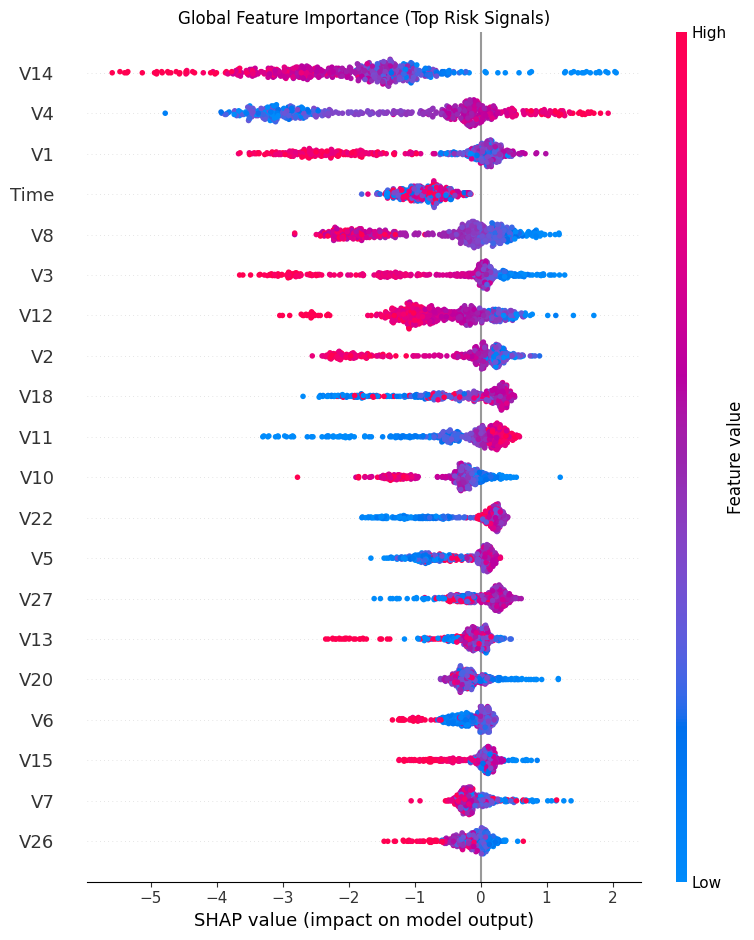

In [ ]:
# 3. Global Summary Plot
plt.figure(figsize=(10, 8))
plt.title("Global Feature Importance (Top Risk Signals)")
shap.summary_plot(shap_values, X_test_subset, show=False)
plt.show()

### 🕵️‍♂️ Analyst View: Local Explanation

**Scenario:**
The model has flagged **Transaction #123** as high-risk. The Analyst pulls up this dashboard to verify.

**How to read the Force Plot:**
- **Base Value:** The average fraud probability.
- **Red bars (Pushing Right):** Features pushing the risk *UP*.
- **Blue bars (Pushing Left):** Features pushing the risk *DOWN*.

In [ ]:
# 4. Find a High-Risk Transaction to Explain
# We look for a transaction where the model predicts Fraud (Class 1)
y_pred_subset = model_pipeline.predict(X_test_subset)
fraud_indices = np.where(y_pred_subset == 1)[0]

if len(fraud_indices) > 0:
    # Pick the first flagged transaction
    idx = fraud_indices[0]
    print(f"🔍 Analyzing Flagged Transaction (Index: {idx})")

    # Initialize JS for the interactive plot
    shap.initjs()

    # Force Plot
    display(shap.force_plot(
        explainer.expected_value,
        shap_values[idx, :],
        X_test_subset.iloc[idx, :]
    ))
else:
    print("No fraud predicted in this subset. Try a larger sample.")

🔍 Analyzing Flagged Transaction (Index: 150)


### 🗣️ Business Interpretation

**How an Analyst uses this:**

> *"I see this transaction was blocked. The SHAP plot shows that **V14** and **V4** are the main drivers (Red bars). In our historical data, high deviations in V14 usually correlate with 'card not present' anomalies. Even though the **Amount** was low (Blue bar), the behavioral risk signal from V14 was strong enough to trigger the block. I will confirm this decision."*

**Conclusion:**
This layer of explainability transforms the model from a mathematical tool into an operational asset. It builds trust with stakeholders and helps satisfy regulatory requirements (Right to Explanation).